<a href="https://colab.research.google.com/github/lathigaa/Anomaly-Detection-Autoencoders/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from numpy import quantile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import linear_model
from sklearn.linear_model import SGDOneClassSVM

from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix,f1_score
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
df.shape


(67434, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67434 entries, 0 to 67433
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    67434 non-null  int64  
 1   V1      67434 non-null  float64
 2   V2      67434 non-null  float64
 3   V3      67434 non-null  float64
 4   V4      67434 non-null  float64
 5   V5      67434 non-null  float64
 6   V6      67434 non-null  float64
 7   V7      67434 non-null  float64
 8   V8      67434 non-null  float64
 9   V9      67434 non-null  float64
 10  V10     67434 non-null  float64
 11  V11     67434 non-null  float64
 12  V12     67434 non-null  float64
 13  V13     67434 non-null  float64
 14  V14     67434 non-null  float64
 15  V15     67434 non-null  float64
 16  V16     67434 non-null  float64
 17  V17     67434 non-null  float64
 18  V18     67434 non-null  float64
 19  V19     67434 non-null  float64
 20  V20     67434 non-null  float64
 21  V21     67433 non-null  float64
 22

In [ ]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [ ]:
# Fill missing values with the mean for columns
for col in ['V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Amount','Class']:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
df['Class'].value_counts()

,count
Class,
0.000000,67264
1.000000,169
0.002506,1


In [ ]:
# Assuming the column that indicates fraud or normal cases is called 'label' (1 for fraud, 0 for normal)
df_fraud = df[df['Class'] == 1]  # Filter rows where the label is 1 (fraud)
df_normal = df[df['Class'] == 0]  # Filter rows where the label is 0 (normal)

outlier_fraction = len(df_fraud)/float(len(df_normal))
print(outlier_fraction)
print("Fraud Cases : {}".format(len(df_fraud)))
print("Normal Cases : {}".format(len(df_normal)))


0.002512488106565176
Fraud Cases : 169
Normal Cases : 67264


<ipython-input-10-e219b3e2fdac>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  classes = pd.value_counts(df['Class'], sort = True)


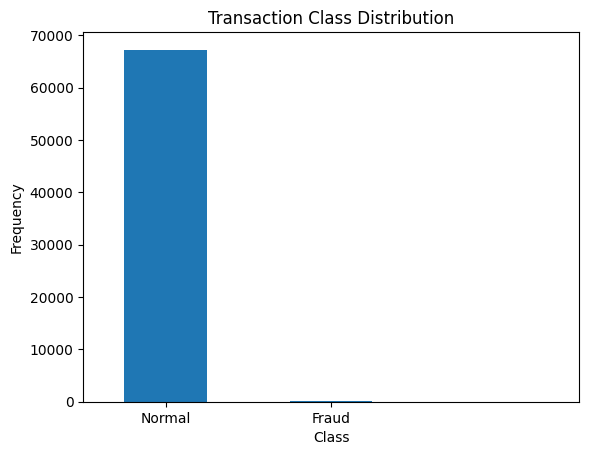

In [ ]:
classes = pd.value_counts(df['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), labels = ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency");

In [ ]:
df[['Class', 'Amount', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5']].describe()

,Class,Amount,Time,V1,V2,V3,V4,V5
count,67434.000000,67434.000000,67434.000000,67434.000000,67434.000000,67434.000000,67434.000000,67434.000000
mean,0.002506,96.628136,33976.974835,-0.241622,-0.018321,0.683462,0.169473,-0.268578
std,0.049999,269.893188,14222.001116,1.857614,1.649726,1.418358,1.377279,1.385175
min,0.000000,0.000000,0.000000,-56.407510,-72.715728,-32.965346,-5.172595,-42.147898
25%,0.000000,7.680000,28238.000000,-1.001783,-0.590074,0.195636,-0.724684,-0.887468
50%,0.000000,26.310000,37354.000000,-0.241551,0.072585,0.772156,0.188286,-0.301379
75%,0.000000,88.500000,44551.000000,1.153782,0.728136,1.405294,1.053095,0.269637
max,1.000000,19656.530000,52534.000000,1.960497,18.183626,4.226108,16.715537,34.801666


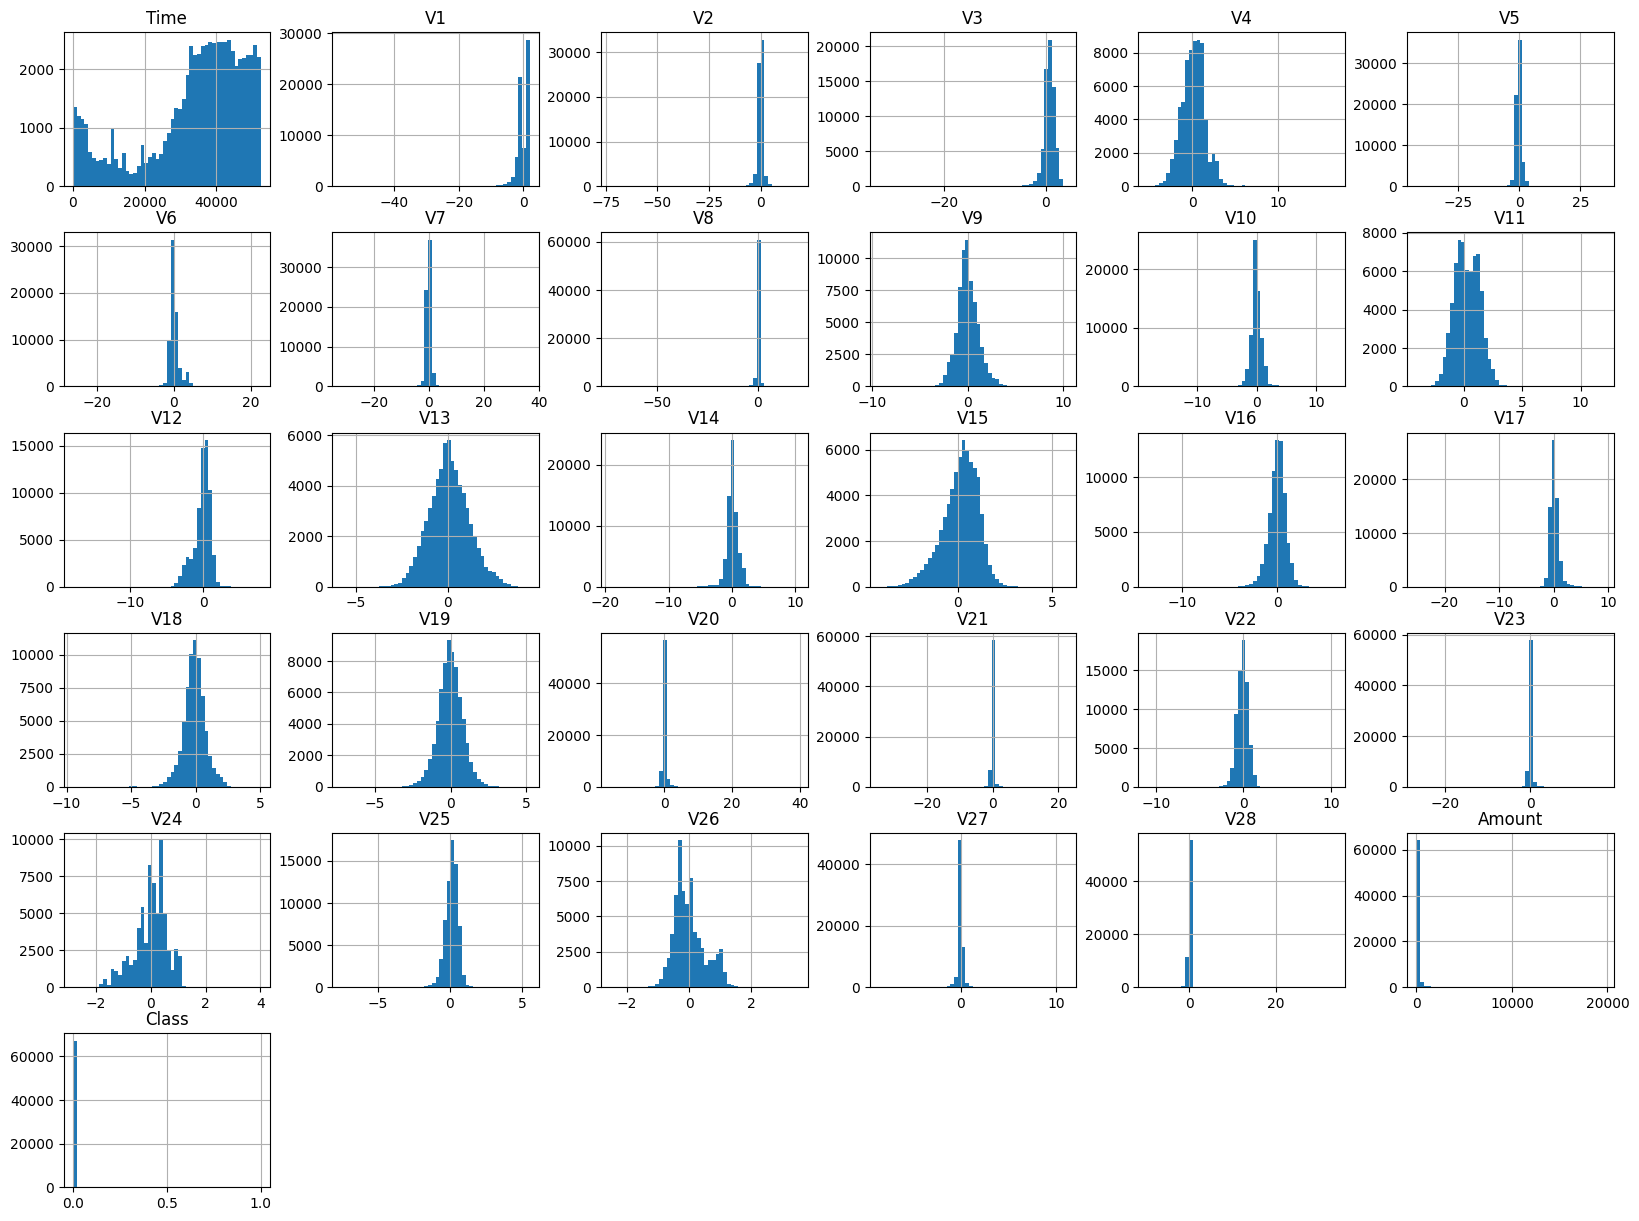

In [ ]:
df.hist(figsize=(20, 15), bins=50);


In [ ]:
df_sc = df.copy()

In [ ]:
df_sc['Time'] = StandardScaler().fit_transform(df_sc['Time'].values.reshape(-1, 1))
df_sc['Amount'] = StandardScaler().fit_transform(df_sc['Amount'].values.reshape(-1, 1))

In [ ]:
train, test = train_test_split(df_sc, test_size=0.3, random_state = 10)

In [ ]:
X_train = train[train['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)

X_test = test.drop(['Class'], axis=1)
y_test = test['Class']


In [ ]:
print(f'X_train shape: {X_train.shape};')
print(f'X_test shape: {X_test.shape}; y_test shape: {y_test.shape}')


X_train shape: (47081, 30);
X_test shape: (20231, 30); y_test shape: (20231,)


In [ ]:
learning_rate = 0.00001
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))

encoder = Dense(16, activation='elu', activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(8, activation='relu')(encoder)
encoder = Dense(4, activation='relu')(encoder)

decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(16, activation='relu')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')


EarlyStop = EarlyStopping(monitor='accuracy', patience=5, verbose=1)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(X_train, X_train,
          epochs=20,
          batch_size = 64,
          validation_data = (X_test, X_test),
          callbacks = EarlyStop,
          shuffle=True)


Epoch 1/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1816 - loss: 0.9652 - val_accuracy: 0.3833 - val_loss: 0.7990
Epoch 2/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4113 - loss: 0.7130 - val_accuracy: 0.4269 - val_loss: 0.7440
Epoch 3/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4395 - loss: 0.6695 - val_accuracy: 0.4362 - val_loss: 0.7165
Epoch 4/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4452 - loss: 0.6652 - val_accuracy: 0.4614 - val_loss: 0.6975
Epoch 5/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4694 - loss: 0.6395 - val_accuracy: 0.4699 - val_loss: 0.6861
Epoch 6/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4778 - loss: 0.6245 - val_accuracy: 0.4931 - val_loss: 0.6757
Epoch 7/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4946 - loss: 0.6167 - val_accuracy: 0.4785 - val_loss: 0.6764
Epoch 8/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4996 - loss: 0.5880 - val_accuracy: 0.

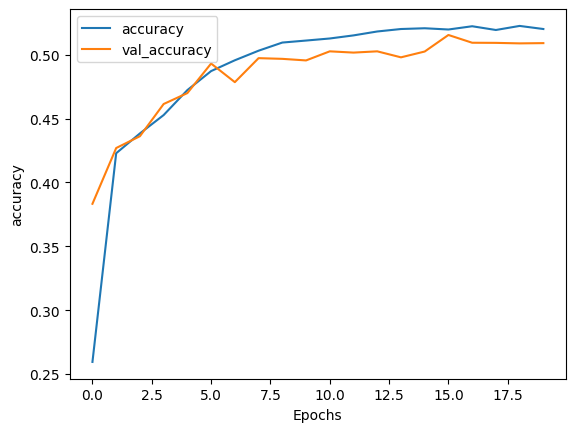

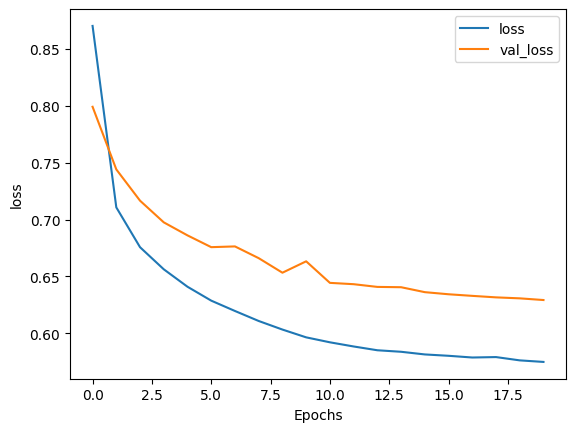

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()



plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
prediction = autoencoder.predict(X_test)

633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'class': y_test})

In [ ]:
error_df.describe()

,reconstruction_error,class
count,20231.000000,20231.000000
mean,0.623044,0.002373
std,3.171913,0.048653
min,0.044394,0.000000
25%,0.187829,0.000000
50%,0.288785,0.000000
75%,0.466456,0.000000
max,132.492912,1.000000


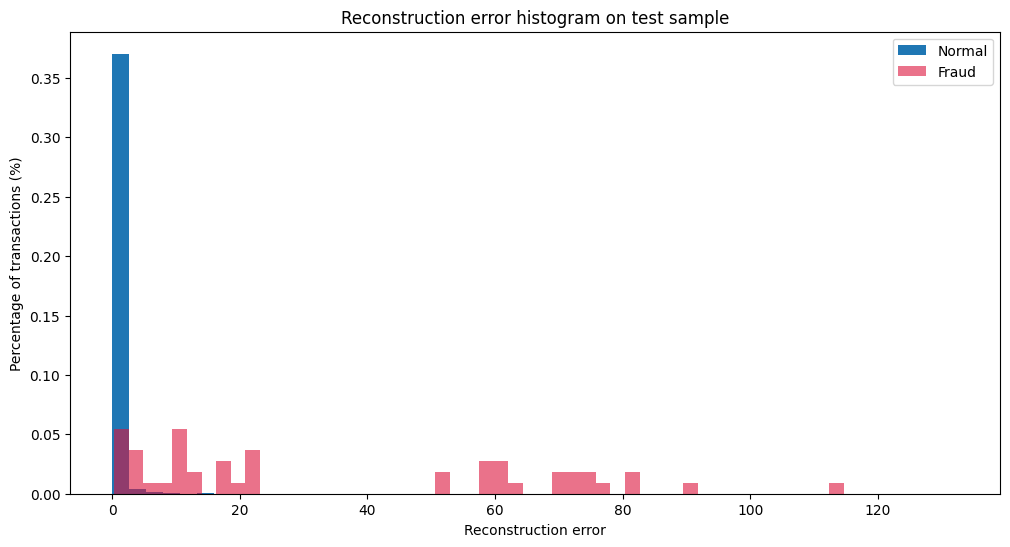

In [ ]:
bins = 50
plt.figure(figsize=(12, 6))
plt.hist(error_df[error_df['class'] == 0]['reconstruction_error'], bins, alpha=1, density=True, label='Normal')
plt.hist(error_df[error_df['class'] == 1]['reconstruction_error'], bins, alpha=0.6, density=True, label='Fraud', color='crimson')
plt.legend(loc='upper right')
plt.title("Reconstruction error histogram on test sample")
plt.xlabel("Reconstruction error")
plt.ylabel("Percentage of transactions (%)");
plt.show()

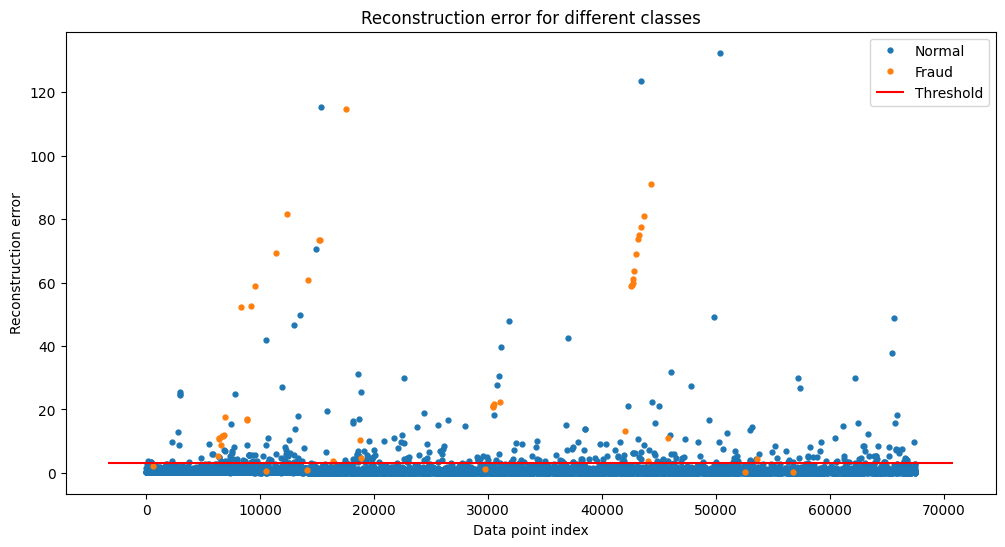

In [ ]:
threshold=3

groups = error_df.groupby('class')
fig, ax = plt.subplots(figsize=(12, 6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
threshold_prediction = [0 if i < threshold else 1 for i in mse]

print(classification_report(y_test, threshold_prediction))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     20183
         1.0       0.11      0.88      0.20        48

    accuracy                           0.98     20231
   macro avg       0.55      0.93      0.59     20231
weighted avg       1.00      0.98      0.99     20231



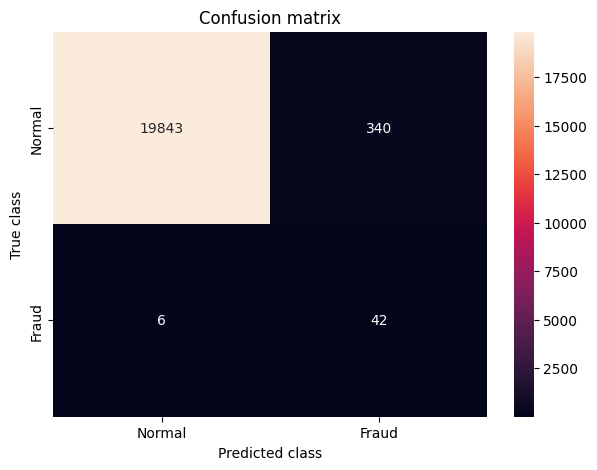

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df['class'], y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, xticklabels=['Normal','Fraud'],
            yticklabels=['Normal','Fraud'],
            annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
